## First models

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import time
import numpy as np

import ast
from collections import Counter

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection, metrics
from nrclex import NRCLex

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bapti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bapti\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bapti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df_train = pd.read_csv("data/train.txt", names=["text", "emotion"], sep=";")
df_test = pd.read_csv("data/test.txt", names=["text", "emotion"], sep=";")
df_train.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


### Data prep

In [3]:
# load stopwords
sw_file = open('misc/stopwords.txt', "r")
try :
    content = sw_file.read()
    stopwords = ast.literal_eval(content)
finally:
    sw_file.close()
    
# separate text and labels
X, y = list(df_train['text']), list(df_train['emotion'])

# Turn labels to numeric
emotion_list = list(df_train['emotion'].unique())
y_names = list(df_train['emotion'])
y = [emotion_list.index(em) for em in y]



In [4]:

def preprocess(text_lst, sw=False, stem=False, lem=True):
    """
    Apply different preprocessing.
    returns :
        - list of texts preprocessed
    params : 
        - list(str) text_lst : list of text to preprocess
        - bool sw : enable to remove stopwords
        - bool stem : enable to stem text
        - bool lem : enable to lemmatize text
    """
    time_start = time.time()
    if sw :
        text_lst = [' '.join([word for word in x.split() if word not in (stopwords)]) for x in text_lst]
    
    stemmer = SnowballStemmer('english')
    lem = WordNetLemmatizer()
    
    if stem and lem :
        text_lst = [' '.join([stemmer.stem(lem.lemmatize(word)) for word in x.split()]) for x in text_lst]
    
    elif stem :
        text_lst = [' '.join([stemmer.stem(word) for word in x.split()]) for x in text_lst]
        
    elif lem :
        text_lst = [' '.join([lem.lemmatize(word) for word in x.split()]) for x in text_lst]
    
    print(f'Time elapsed : {round(time.time() - time_start, 2)} s')
    
    return text_lst

#X_preproc = preprocess(X, sw=False, stem=True, lem=True)

### Models

### #1 Simple classification with tf/idf

#### Text encoding : tf/idf with refined vocabulary

In [5]:
# preprocessing for vocabulary creation
X_preproc = preprocess(X, sw=False, stem=False, lem=False)

Time elapsed : 1.92 s


In [6]:
# tfidf vectorizer
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))
vectorizer.fit(X_preproc)
X_train = vectorizer.transform(X_preproc)
vocabulary = vectorizer.vocabulary_ # getting vocabulary

In [7]:
# Chi square test to test features independancy : dimensionality reduction
# print below features linked to each subject

X_names = vectorizer.get_feature_names()
p_val = .95

features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    features = features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    features = features.sort_values(["y","score"], 
                    ascending=[True,False])
    features = features[features["score"]>p_val]

X_names = features["feature"].unique().tolist()

for cat in np.unique(y):
    print(f'# {emotion_list[cat]}')
    print(f'Top features selected : {len(features[features["y"]==cat])}')
    print(features[features["y"]==cat]["feature"].values[:10])
    print()

# sadness
Top features selected : 612
['gloomy' 'disheartened' 'exhausted' 'discouraged' 'miserable'
 'melancholy' 'listless' 'punished' 'homesick' 'shitty']

# anger
Top features selected : 248
['angry' 'annoyed' 'bitchy' 'bitter' 'bothered' 'cold' 'cranky'
 'dangerous' 'dissatisfied' 'distracted']

# love
Top features selected : 217
['caring' 'compassionate' 'delicate' 'fond' 'fond of' 'gentle' 'horny'
 'hot' 'liked' 'longing']

# surprise
Top features selected : 151
['amazed' 'amazed at' 'amazing' 'curious' 'curious about' 'dazed'
 'dazed and' 'feel amazed' 'feel curious' 'feel funny']

# fear
Top features selected : 258
['anxious' 'apprehensive' 'distraught' 'distressed' 'fearful' 'frantic'
 'frightened' 'hesitant' 'insecure' 'intimidated']

# joy
Top features selected : 625
['successful' 'rich' 'brave' 'honored' 'useful' 'divine' 'festive'
 'confident' 'innocent' 'satisfied']



In [8]:
# vectorizer with our new reduced vocabulary as input

vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(X_preproc)
X_train = vectorizer.transform(X_preproc)
voc = vectorizer.vocabulary_


In [9]:
print(X_train.shape[0])
print(len(y))

16000
16000


#### First model : Naive bayes

In [10]:
classifier = naive_bayes.MultinomialNB()

# creating a pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer), ("classifier", classifier)])
model["classifier"].fit(X_train, y)

# Test set preparation
X_test = list(df_test["text"])
X_test_preproc = preprocess(X_test, sw=True, stem=False, lem=True)
y_test = [emotion_list.index(em) for em in list(df_test["emotion"])]

# prediction
predicted = model.predict(X_test_preproc)
predicted_prob = model.predict_proba(X_test_preproc)


Time elapsed : 0.11 s


Accuracy: 0.9

Details :
0 : sadness
1 : anger
2 : love
3 : surprise
4 : fear
5 : joy
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       581
           1       0.93      0.87      0.90       275
           2       0.94      0.60      0.74       159
           3       1.00      0.44      0.61        66
           4       0.89      0.83      0.86       224
           5       0.86      0.98      0.92       695

    accuracy                           0.90      2000
   macro avg       0.92      0.78      0.83      2000
weighted avg       0.90      0.90      0.89      2000




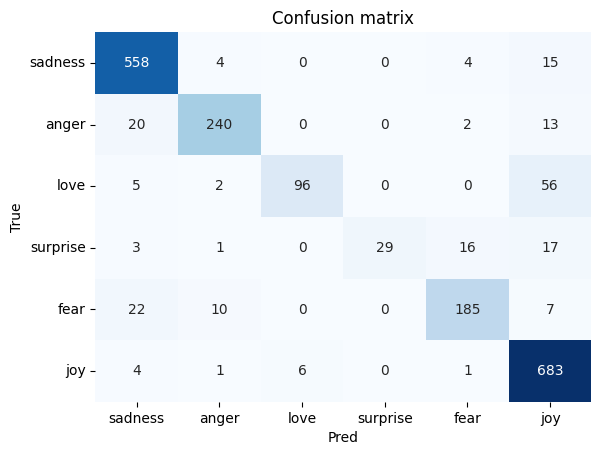

In [11]:
### Results

emotions = np.unique(y_test)

def evaluate_model(expected, predicted):
    '''
    Function print :
    - Global accuracy
    - Detailed precision, recall, f1
    - Confusion matrix
    '''
    # Metrics
    accuracy = metrics.accuracy_score(expected, predicted)
    #auc = metrics.roc_auc_score(expected, predicted_prob, 
    #                            multi_class="ovr")
    print("Accuracy:",  round(accuracy,2))
    #print("Auc:", round(auc,2))
    print()
    print("Details :")
    for idx, em in enumerate([emotion_list[em] for em in emotions]) :
        print(f'{idx} : {em}')
    print(metrics.classification_report(expected, predicted))

    # Plot confusion matrix
    cm = metrics.confusion_matrix(expected, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=[emotion_list[em] for em in emotions], 
           yticklabels=[emotion_list[em] for em in emotions], title="Confusion matrix")
    plt.yticks(rotation=0)
    print()

evaluate_model(y_test, predicted)

#### Lm based approach : Bert

In [22]:
# imports
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertTokenizer
import random
import tabulate
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from tqdm import trange

In [23]:
# load tokenizer
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [24]:
# load corpus and labels
text, y = list(df_train['text']), list(df_train['emotion']) # taking raw text
labels = [emotion_list.index(em) for em in y]
df_val = pd.read_csv("data/val.txt", names=["text", "emotion"], sep=";") 

# adding val set (to get the maxlen) --> resplitting it later
text.extend(list(df_val['text']))
labels.extend([emotion_list.index(em) for em in list(df_val['emotion'])])

# determining maxlen needed
maxlen = 0
for sent in list(text):
    if len(sent) > maxlen :
        maxlen = len(sent.split(' '))
print(f'max len : {maxlen}')


max len : 18


Preprocessing

In [25]:
## BERT preprocessing requirements
# Adding CLS and END tokens, normalize sentence length, create attention mask

def bert_preprocess(text, tokenizer):
    """
    Apply preprocessing needed for bert. see comment above
    """
    return tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = 25,
        pad_to_max_length = True,
        return_attention_mask = True,
        truncation = True,
        return_tensors = 'pt',
    )

token_id = []
attention_masks = []

for sentence in text:
    encoding_dict = bert_preprocess(sentence, tokenizer)
    token_id.append(encoding_dict['input_ids']) 
    attention_masks.append(encoding_dict['attention_mask'])

token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

print(f'Sentence tokenized example :\n{text[0]} :\n{token_id[0]}')


Sentence tokenized example :
i didnt feel humiliated :
tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])


In [26]:
val_ratio = .2
batch_size = 16

# resplitting val set
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# train set 80%
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

# validation set 20%
val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

train_val_set = TensorDataset(token_id[:], 
                        attention_masks[:], 
                        labels[:])


# dataloaders
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

train_val_dataloader = DataLoader(
    train_val_set,
    sampler = SequentialSampler(train_val_set),
    batch_size = batch_size
            
)



Fine-tuning :
- hyperparameters based on https://arxiv.org/pdf/1810.04805.pdf

In [27]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 6,
    output_attentions = False,
    output_hidden_states = False,
)

optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

model.cuda() # comment if no gpu available

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def train_model(model, epochs, full_train=False):
    '''
    Function to train model.
    params :
        - model model
        - int epochs
        - boolean full_train : if enabled, train model on train + val set
    return : 
        - model
    '''
    
    all_acc = [] # list of accuracy at different epochs
    
    msg = f'Currently : training model on train set, evaluate on validation set. {epochs} epochs.'
    if full_train :
        msg = f'Currently : training model on train + validation set for perf. {epochs} epochs.'
    print(msg)

    # training template
    for _ in trange(epochs, desc = 'Epoch'):

        # ========== Training ==========

        # Set model to training mode
        model.train()

        # Tracking variables
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        
        loader = train_dataloader
        if full_train :
            loader = train_val_dataloader

        for step, batch in enumerate(loader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            optimizer.zero_grad()
            # Forward pass
            train_output = model(b_input_ids, 
                                 token_type_ids = None, 
                                 attention_mask = b_input_mask, 
                                 labels = b_labels)
            # Backward pass
            train_output.loss.backward()
            optimizer.step()
            # Update tracking variables
            tr_loss += train_output.loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1

        # ========== Validation ==========
        if not full_train :
            # Set model to evaluation mode
            model.eval()

            # Tracking variables 
            loss_lst = []
            all_expected = []
            all_predicted = []

            for batch in validation_dataloader:
                batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch
                with torch.no_grad():
                  # Forward pass
                  eval_output = model(b_input_ids, 
                                      token_type_ids = None, 
                                      attention_mask = b_input_mask)
                logits = eval_output.logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # Calculate validation metrics
                preds = np.argmax(logits, axis = 1).flatten()

                all_expected.extend(list(label_ids))
                all_predicted.extend(list(preds))

                # Update recall only when (tp + fn) != 0
                if b_recall != 'nan':
                    val_recall.append(b_recall)

            loss_lst.append(tr_loss)
            print('\n\t # Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
            accuracy = metrics.accuracy_score(all_expected, all_predicted)
            print(f'\tAccuracy : {round(accuracy, 2)}')
            all_acc.append(round(accuracy, 2))
    return model, all_acc


cuda


Evaluating model

In [32]:
# --> should grid search on optimizer hyperparameters

In [ ]:
model, all_acc = train_model(model, epochs = 6, full_train=False)

Currently : training model on train set, evaluate on validation set. 6 epochs.


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
plt.plot(all_acc)

Full training model

In [ ]:
model_full_trained = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 6,
    output_attentions = False,
    output_hidden_states = False,
)

optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

model_full_trained.cuda() # comment if no gpu available

model_full_trained, all_acc = train_model(model, epochs = 6, full_train=True)

Testing results

In [115]:
# load test data

# preparing test data
token_id = []
attention_masks = []

df_test = pd.read_csv("data/test.txt", names=["text", "emotion"], sep=";")
labels_test = [emotion_list.index(em) for em in df_test['emotion']]
test_text = list(df_test['text'])


for sentence in test_text:
    encoding_dict = bert_preprocess(sentence, tokenizer)
    token_id.append(encoding_dict['input_ids']) 
    attention_masks.append(encoding_dict['attention_mask'])

token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels_test = torch.tensor(labels_test)


test_set = TensorDataset(token_id[:], 
                        attention_masks[:], 
                        labels_test[:])



test_dataloader = DataLoader(
            test_set,
            sampler = SequentialSampler(test_set),
            batch_size = batch_size
        )



In [116]:
all_expected = []
all_predicted = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      # Forward pass
      eval_output = model_full_trained(b_input_ids, 
                          token_type_ids = None, 
                          attention_mask = b_input_mask)
    logits = eval_output.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    preds = np.argmax(logits, axis = 1).flatten()
    
    all_expected.extend(list(label_ids))
    all_predicted.extend(list(preds))
print('done')

done


Accuracy: 0.82

Details :
0 : sadness
1 : anger
2 : love
3 : surprise
4 : fear
5 : joy
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       581
           1       0.88      0.73      0.80       275
           2       0.73      0.68      0.71       159
           3       0.81      0.59      0.68        66
           4       0.87      0.71      0.78       224
           5       0.74      0.94      0.83       695

    accuracy                           0.82      2000
   macro avg       0.83      0.74      0.78      2000
weighted avg       0.83      0.82      0.82      2000




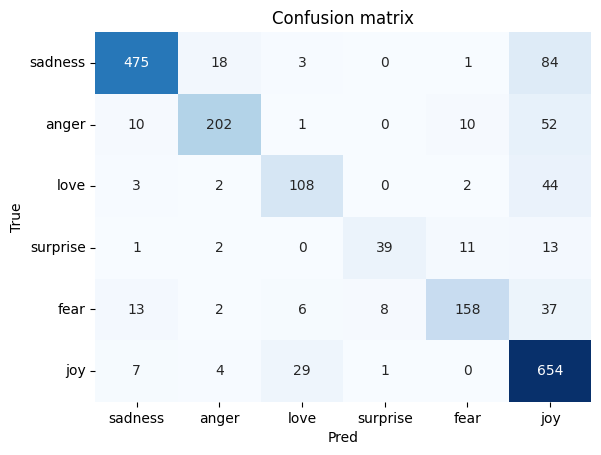

In [234]:
# evaluate results
evaluate_model(all_expected, all_predicted)

## Results

In [225]:
print(f'Accuracy with simple tf/idf : 0.77')
print('Accuracy with refined vocabulary : 0.9')
print('Accuracy for now with bert : 0.82')

Accuracy with simple tf/idf : 0.77
Accuracy with refined vocabulary : 0.9
Accuracy for now with bert : 0.82
